In [46]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import math

from scipy.odr import ODR, Model, Data, RealData
from IPython.display import HTML, display
from scipy.special import ellipk, ellipe
from matplotlib.colors import Normalize

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [135]:
class Ising2D():

    def __init__(self, lattice_size: int, H: float, dH: float, nH: int, T: float, BC1: str, BC2: str):
        self.L = lattice_size  
        self.N = self.L**2     
        self.BC1 = BC1
        self.BC2 = BC2
        self.spins = np.ones((self.L, self.L), dtype = float) 
        self.spins_list = []                                  
        self.u = 1   
        self.J = 1  
        self.H = H   
        self.H_temp = []
        self.dH = dH
        self.nH = nH
        self.m_temp_list = []
        self.mAvePerH_list = []
        self.mPerH_list = []
        self.T = T   
        self.kB = 1  
        self.e = 0        
        self.m = 0       
        self.C = 0        
        self.X = 0        
        self.e_list = []  
        self.m_list = [] 
        self.E = 0              
        self.M = 0              
        self.H_list = []
        self.mtemp_list = []
        self.E_list = []        
        self.M_list = []        
        self.save_spins = None  
        self.num_steps = 0     
        self.steps_list = []    
        
    def _append(self):
        self.E_list.append(self.E)
        self.M_list.append(self.M)
        if self.save_spins:
            self.spins_list.append(np.copy(self.spins))

    def _thermodynamic_variables(self):
        equilibrium = 4 * self.tot_steps // 5 
        E_mean = np.mean(self.E_list[equilibrium:])          
        E_var = np.var(self.E_list[equilibrium:], ddof = 1) 
        self.e = E_mean / self.N                             
        self.e_list = [E / self.N for E in self.E_list]     
        M_mean = np.mean(self.M_list[equilibrium:])                    
        Mabs_var = np.var(np.abs(self.M_list[equilibrium:]), ddof = 1)  
        self.m = M_mean / self.N                                       
        self.m_list = [M / self.N for M in self.M_list]                
        self.C = E_var / (self.kB * self.T**2 * self.N)  
        self.X = Mabs_var / (self.kB * self.T * self.N)  
     
        

    def _step(self):
        i, j = np.random.randint(0, self.L, size = 2)
        l = self.spins[i, (j - 1) % self.L]  
        r = self.spins[i, (j + 1) % self.L]  
        a = self.spins[(i - 1) % self.L, j]  
        b = self.spins[(i + 1) % self.L, j]  
        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
            self.spins[i, j] *= -1        
            self.E += dE                    
            self.M += 2 * self.spins[i, j]  
        self._append()

    def _gradient_step(self):
        i, j = np.random.randint(0, self.L, size = 2)
        l = self.spins[i, (j - 1) % self.L]  
        r = self.spins[i, (j + 1) % self.L] 
        a = self.spins[(i - 1) % self.L, j]  
        self.H = self.gradient[i,j]
        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
            self.spins[i, j] *= -1         
            self.E += dE                    
            self.M += 2 * self.spins[i, j] 
        self._append()
        
    def Metropolis(self, num_steps: int, save_spins = False):
        self.num_steps = num_steps
        self.tot_steps = num_steps * self.N
        self.steps_list = [step for step in range(self.tot_steps + 1)]
        self.save_spins = save_spins
        self.M = np.sum(self.spins)                                
        self.E = -2 * self.J * self.N + self.u * self.H * self.N   
        self._append()
        if self.BC1 == 'Step':
            for change in range(nH+1):
                for step in range(self.tot_steps//(nH + 1)):
                    self._step()
                    self.H_list.append(self.H)
                self.H = self.H - dH
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                self._step()
                self.H_list.append(self.H)
            self.H = self.H - dH/self.tot_steps
        self._thermodynamic_variables()

    def IHyst(self, num_steps: int, save_spins = False):
        self.num_steps = num_steps
        self.H = H
        self.H_temp = np.arange(-self.H, self.H,dH/self.num_steps)
        self.tot_steps = len(self.H_temp)
        self.steps_list = [step for step in range(self.tot_steps + 1)]
        self.save_spins = save_spins
        self.M = np.sum(self.spins)                                
        self.E = -2 * self.J * self.N + self.u * self.H * self.N   
        self._append()
        if self.BC1 == 'Step':
            for change in self.H_temp:
                for step in range(nH + 1):
                    self._step()
                    self.H_list.append(-change)
                self.H = -change
            for change in self.H_temp:
                for step in range(nH + 1):
                    self._step()
                    self.H_list.append(change)
                self.H = change
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                self._step()
                self.H_list.append(self.H)
                self.H = self.H - dH/self.tot_steps
        self._thermodynamic_variables()

    def _initialize_matrix(self):
        matrix = []
        for i in range(L):
            row = []
            for j in range(L):
                row.append(0.0)
            matrix.append(row)
        return matrix

    def _set_matrix(self):
        center = L // 2
        H_matrix = self._initialize_matrix()
        max_distance = math.sqrt((center) ** 2 + (center) ** 2)
        for i in range(L):
            for j in range(L):
                distance = math.sqrt((i - center) ** 2 + (j - center) ** 2)
                H_matrix[i][j] = round(H * (1 - (distance / max_distance) ** 2), 2)
        return H_matrix

    def Gradient(self, num_steps, save_spins = False):
        self.num_steps = num_steps
        self.tot_steps = num_steps * self.N
        self.steps_list = [step for step in range(self.tot_steps + 1)]
        self.save_spins = save_spins
        self.M = np.sum(self.spins)                                
        
        if self.BC2 == "linear":
            self.gradient = np.linspace(0, H, self.L)
            self.H = np.mean(self.gradient)
            self.E = -2 * self.J * self.N + self.u * self.H * self.N  
            self._append()
            if self.BC1 == 'Step':
                for change in range(nH+1):
                    for step in range(self.tot_steps//(nH + 1)):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j]  
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient[i]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()


                    
                    self.H_list.append(self.H)
                self.H = self.H - dH
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                i, j = np.random.randint(0, self.L, size = 2)
                l = self.spins[i, (j - 1) % self.L]  
                r = self.spins[i, (j + 1) % self.L] 
                a = self.spins[(i - 1) % self.L, j]  
                b = self.spins[(i + 1) % self.L, j]
                self.H = self.gradient[i]
                dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                    self.spins[i, j] *= -1         
                    self.E += dE                    
                    self.M += 2 * self.spins[i, j] 
                self._append()

                self.H_list.append(self.H)
                self.H = self.H - dH/self.tot_steps
        elif self.BC2 == "wave":
            g1 = np.linspace(0,H,self.L//2)
            g2 = np.linspace(H,0,self.L//2)
            self.gradient_wave = np.concatenate((g1, g2))
            self.H = np.mean(self.gradient_wave)
            self.E = -2 * self.J * self.N + self.u * self.H * self.N  
            self._append()
            if self.BC1 == 'Step':
                for change in range(nH+1):
                    for step in range(self.tot_steps//(nH + 1)):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j]  
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient_wave[i]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()
                    self.H_list.append(self.H)
                self.H = self.H - dH
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                i, j = np.random.randint(0, self.L, size = 2)
                l = self.spins[i, (j - 1) % self.L]  
                r = self.spins[i, (j + 1) % self.L] 
                a = self.spins[(i - 1) % self.L, j]  
                b = self.spins[(i + 1) % self.L, j]
                self.H = self.gradient_wave[i]
                dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                    self.spins[i, j] *= -1         
                    self.E += dE                    
                    self.M += 2 * self.spins[i, j] 
                self._append()
                self.H_list.append(self.H)
                self.H = self.H - dH/self.tot_steps
        elif self.BC2 == "radial":
            self.gradient_matrix = self._set_matrix()
            self.H = np.mean(self.gradient_matrix)
            self.E = -2 * self.J * self.N + self.u * self.H * self.N  
            if self.BC1 == 'Step':
                for change in range(nH+1):
                    for step in range(self.tot_steps//(nH + 1)):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j] 
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient_matrix[i][j]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()
                    self.H_list.append(self.H)
                self.H = self.H - dH
            self.e_list.append(-.1)
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                i, j = np.random.randint(0, self.L, size = 2)
                l = self.spins[i, (j - 1) % self.L]  
                r = self.spins[i, (j + 1) % self.L] 
                a = self.spins[(i - 1) % self.L, j]  
                b = self.spins[(i + 1) % self.L, j]
                self.H = self.gradient_wmatrix[i][j]
                dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                    self.spins[i, j] *= -1         
                    self.E += dE                    
                    self.M += 2 * self.spins[i, j] 
                self._append()
                self.H_list.append(self.H)
                self.H = self.H - dH/self.tot_steps
        else:
            raise ValueError("Invalid gradient_type. Choose from 'constant', 'linear', 'radial', or 'random'.")
        
        self._thermodynamic_variables()



    def GHyst(self, num_steps, save_spins = False):
        self.num_steps = num_steps
        self.H = H
        self.H_temp = np.arange(-self.H, self.H,dH/self.num_steps)
        self.tot_steps = len(self.H_temp)
        self.steps_list = [step for step in range(self.tot_steps + 1)]
        self.save_spins = save_spins
        self.M = np.sum(self.spins)                                
        if self.BC2 == "linear":
            self.gradient = np.linspace(0, H, self.L)
            self.H = np.mean(self.gradient)
            self.E = -2 * self.J * self.N + self.u * self.H * self.N  
            self._append()
            if self.BC1 == 'Step':
                for change in self.H_temp:
                    for step in range(nH + 1):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j]  
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient[i]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()


                    
                    self.H_list.append(-change)
                self.H = -change
                for change in self.H_temp:
                    for step in range(nH + 1):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j]  
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient[i]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()


                    
                    self.H_list.append(change)
                self.H = change
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                i, j = np.random.randint(0, self.L, size = 2)
                l = self.spins[i, (j - 1) % self.L]  
                r = self.spins[i, (j + 1) % self.L] 
                a = self.spins[(i - 1) % self.L, j]  
                b = self.spins[(i + 1) % self.L, j]
                self.H = self.gradient[i]
                dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                    self.spins[i, j] *= -1         
                    self.E += dE                    
                    self.M += 2 * self.spins[i, j] 
                self._append()

                self.H_list.append(self.H)
                self.H = self.H - dH/self.tot_steps
        elif self.BC2 == "wave":
            g1 = np.linspace(0,H,self.L//2)
            g2 = np.linspace(H,0,self.L//2)
            self.gradient_wave = np.concatenate((g1, g2))
            self.H = np.mean(self.gradient_wave)
            self.E = -2 * self.J * self.N + self.u * self.H * self.N  
            self._append()
            if self.BC1 == 'Step':
                for change in self.H_temp:
                    for step in range(nH + 1):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j]  
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient_wave[i]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()
                    self.H_list.append(-change)
                self.H = -change
                for change in self.H_temp:
                    for step in range(nH + 1):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j]  
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient_wave[i]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()
                    self.H_list.append(change)
                self.H = change
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                i, j = np.random.randint(0, self.L, size = 2)
                l = self.spins[i, (j - 1) % self.L]  
                r = self.spins[i, (j + 1) % self.L] 
                a = self.spins[(i - 1) % self.L, j]  
                b = self.spins[(i + 1) % self.L, j]
                self.H = self.gradient_wave[i]
                dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                    self.spins[i, j] *= -1         
                    self.E += dE                    
                    self.M += 2 * self.spins[i, j] 
                self._append()
                self.H_list.append(self.H)
                self.H = self.H - dH/self.tot_steps
        elif self.BC2 == "radial":
            self.gradient_matrix = self._set_matrix()
            self.H = np.mean(self.gradient_matrix)
            self.E = -2 * self.J * self.N + self.u * self.H * self.N  
            if self.BC1 == 'Step':
                for change in range(nH+1):
                    for step in range(self.tot_steps//(nH + 1)):
                        i, j = np.random.randint(0, self.L, size = 2)
                        l = self.spins[i, (j - 1) % self.L]  
                        r = self.spins[i, (j + 1) % self.L] 
                        a = self.spins[(i - 1) % self.L, j] 
                        b = self.spins[(i + 1) % self.L, j]
                        self.H = self.gradient_matrix[i][j]
                        dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                        if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                            self.spins[i, j] *= -1         
                            self.E += dE                    
                            self.M += 2 * self.spins[i, j] 
                        self._append()
                    self.H_list.append(self.H)
                self.H = self.H - dH
            self.e_list.append(-.1)
        elif self.BC1 == 'Continuous':
            for step in range(self.tot_steps):
                i, j = np.random.randint(0, self.L, size = 2)
                l = self.spins[i, (j - 1) % self.L]  
                r = self.spins[i, (j + 1) % self.L] 
                a = self.spins[(i - 1) % self.L, j]  
                b = self.spins[(i + 1) % self.L, j]
                self.H = self.gradient_wmatrix[i][j]
                dE = 2 * self.spins[i, j] * (self.J * (l + r + a + b) + self.u * self.H)
                if dE <= 0 or np.random.rand() < np.exp(-dE / (self.kB * self.T)):
                    self.spins[i, j] *= -1         
                    self.E += dE                    
                    self.M += 2 * self.spins[i, j] 
                self._append()
                self.H_list.append(self.H)
                self.H = self.H - dH/self.tot_steps
        else:
            raise ValueError("Invalid gradient_type. Choose from 'constant', 'linear', 'radial', or 'random'.")
        
        self._thermodynamic_variables()    
        
    def plot_em(self, save_fig = False):
        fig = plt.figure(figsize = (16, 7))
        fig.tight_layout(pad = 2)
        gs = gridspec.GridSpec(2, 4, height_ratios=[6, 1])
        gs.update(hspace = 0.5)
        gs.update(wspace = 0.35)
        ax1 = plt.subplot(gs[0, :2])
        ax1.set_xlabel('Steps')
        ax1.set_ylabel(r'$E\ /\ N\,J$')
        ax1.set_title(f'Mean Energy Per Particle (L = {self.L},  H = {H}T to {round(self.H+0.1,2)}T, dH = {self.dH}, T = {self.T})')
        ax1.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
        change_show = [self.tot_steps/5, 2*self.tot_steps/5, 3*self.tot_steps/5,4*self.tot_steps/5]
        for val in change_show:
            ax1.axvline(x=val, color='black', linestyle = 'dashed')
        ax1.plot(self.steps_list[::100], self.e_list[::100], linestyle = 'solid', color = 'black')
        ax2 = plt.subplot(gs[0, 2:])
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('$m$')
        ax2.set_title(f'Mean Magnetization Per Particle (L = {self.L}, H = {H}T to {round(self.H+0.1,2)}T, dH = {self.dH}, T = {self.T})')
        ax2.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
        change_show = [self.tot_steps/5, 2*self.tot_steps/5, 3*self.tot_steps/5,4*self.tot_steps/5]
        for val in change_show:
            ax2.axvline(x=val, color='black', linestyle = 'dashed')
        ax2.plot(self.steps_list[::100], self.m_list[::100], linestyle = 'solid', color = 'black')
        if save_fig:
            fig.savefig('X:\\school\\spring 2024\\thermo\\{N}Spins_H{H}_T{T}_em.png'.format(
                         N = self.N, H = self.H, T = self.T,), bbox_inches = 'tight')

    def plot_em1(self, save_fig = False):
        fig = plt.figure(figsize = (16, 7))
        fig.tight_layout(pad = 2)
        gs = gridspec.GridSpec(2, 4, height_ratios=[6, 1])
        gs.update(hspace = 0.5)
        gs.update(wspace = 0.35)
        ax1 = plt.subplot(gs[0, :2])
        ax1.set_xlabel('Steps')
        ax1.set_ylabel(r'$E\ /\ N\,J$')
        ax1.set_title(f'Mean Energy Per Particle (L = {self.L},  H = {H}T to {round(self.H+0.1,2)}T, dH = {self.dH}, T = {self.T})')
        ax1.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
        change_show = [self.tot_steps/5, 2*self.tot_steps/5, 3*self.tot_steps/5,4*self.tot_steps/5]
        for val in change_show:
            ax1.axvline(x=val, color='black', linestyle = 'dashed')
        ax1.plot(self.steps_list[::100], self.e_list[::100], linestyle = 'solid', color = 'black')
        ax2 = plt.subplot(gs[0, 2:])
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('$m$')
        ax2.set_title(f'Mean Magnetization Per Particle (L = {self.L}, H = {H}T to {round(self.H+0.1,2)}T, dH = {self.dH}, T = {self.T})')
        ax2.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
        change_show = [self.tot_steps/5, 2*self.tot_steps/5, 3*self.tot_steps/5,4*self.tot_steps/5]
        for val in change_show:
            ax2.axvline(x=val, color='black', linestyle = 'dashed')
        ax2.plot(self.steps_list[::100], self.m_list[::100], linestyle = 'solid', color = 'black')
        if save_fig:
            fig.savefig('X:\\school\\spring 2024\\thermo\\{N}Spins_H{H}_T{T}_em.png'.format(
                         N = self.N, H = self.H, T = self.T,), bbox_inches = 'tight')

    def plot_emh(self, save_fig = False):
        fig = plt.figure(figsize = (16, 7))
        fig.tight_layout(pad = 2)
        gs = gridspec.GridSpec(2, 4, height_ratios=[6, 1])
        gs.update(hspace = 0.5)
        gs.update(wspace = 0.35)
        ax2 = plt.subplot(gs[0, :2])
        ax2.set_xlabel('H')
        ax2.set_ylabel('$m$')
        ax2.set_title(f'Mean Magnetization versus H (L = {self.L}, T = {self.T})')
        ax2.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
        ax2.plot(self.H_list, self.m_list[1:], linestyle = 'solid', color = 'black')
        if save_fig:
            fig.savefig('X:\\school\\spring 2024\\thermo\\{N}Spins_H{H}_T{T}_em.png'.format(
                         N = self.N, H = self.H, T = self.T,), bbox_inches = 'tight')
    
    def plot_spins(self, save_fig = False):
        fig, ax = plt.subplots(1, 1, figsize = (8, 8))
        ax.set_aspect('equal', 'box')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{self.L}x{self.L} Lattice of Spins at Equilibrium (L = {self.L},  H = {H}T to {round(self.H+0.1,2)}T, dH = {self.dH}, T = {self.T}')        
        im = ax.imshow(self.spins, cmap = 'binary_r', interpolation = 'nearest', norm = Normalize(vmin = -1, vmax = 1))
        cbar = fig.colorbar(im, ax = ax, shrink = 0.805, ticks = [-1, 1], boundaries = [-2, 0, 2])
        cbar.ax.set_yticklabels(['Down', 'Up'])
        cbar.ax.tick_params(left = False, right = False)        
        if save_fig:
            fig.savefig('X:\\school\\spring 2024\\thermo\\{N}Spins_H{H}_T{T}_spins.png'.format(
                         N = self.N, H = self.H, T = self.T))
       
    def _update_spins(self, step, fig, ax):
        ax.clear()
        ax.set_aspect('equal', 'box')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{self.L}x{self.L} Lattice of Spins (L = {self.L},  H = {H}T to {round(self.H+0.1,2)}T, dH = {self.dH}, T = {self.T}, Step = {step})')        
        im = ax.imshow(self.spins_list[step], cmap = 'binary_r', interpolation = 'nearest',
                       norm = Normalize(vmin = -1, vmax = 1))       
        return fig, ax
    
    def animate_spins(self, save_fig = False):   
        fig, ax = plt.subplots(1, 1, figsize = (8, 8))
        ax.set_aspect('equal', 'box')
        ax.set_xticks([])
        ax.set_yticks([])
        
        #animation parameters
        num_frames = 100                                      #number of frames in animation
        step_size = self.tot_steps // num_frames              #step size for the frames
        frames = np.arange(0, self.tot_steps + 1, step_size)  #set frames to plot in animation
        frames[-1] = self.tot_steps                           #set final frame to be the last step
        
        #create animation
        ani = animation.FuncAnimation(fig, self._update_spins, interval = 75, frames = frames,
                                      fargs = (fig, ax), repeat = False)
        html = HTML(ani.to_jshtml())
        display(html)
        plt.close()
        
        #save animation
        if save_fig:
            f = r'X:\\school\\spring 2024\\thermo\\{N}Spins_spins_.gif'.format(N = self.N, H = round(self.H,2),
                                                                                            T = self.T)
            writergif = animation.PillowWriter(fps = 10)
            ani.save(f, writer = writergif)

$\textbf{Part A.}$
Set $H=0.2$ and $T=3$ and estimate the approximate value of the magnetization. Then change the field to $H=0.1$ and continue updating the spins so that the simulation is continued from the last microstate. Note the value of $m$. Continue this procedure for $H=0$ then $H=-0.1$ and $H=-0.2$. Do your values of $m$ change abruptly as you change the field? Is there any indication of a phase transition as you change $H$?

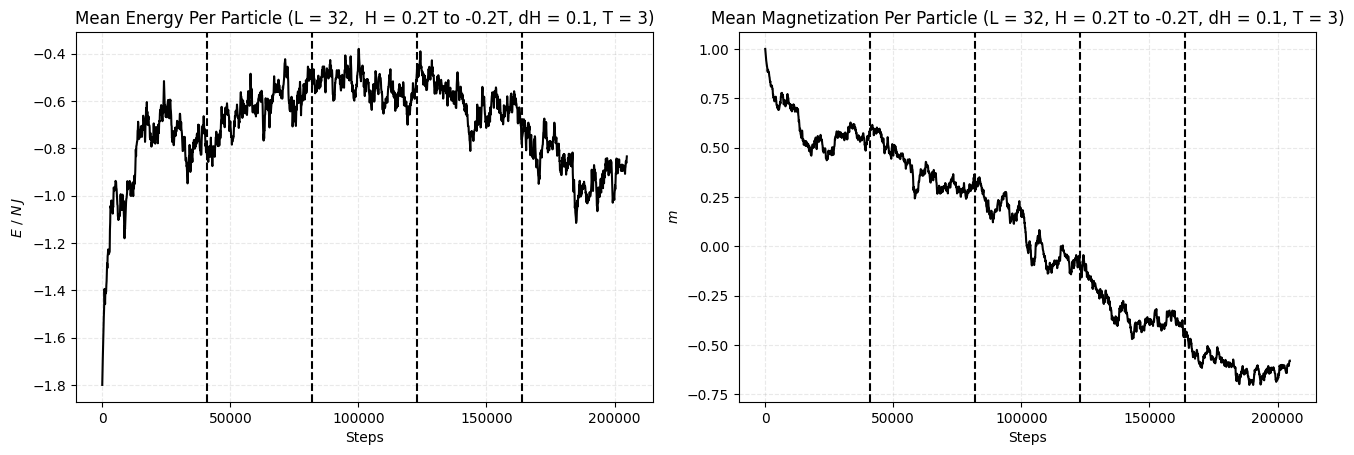

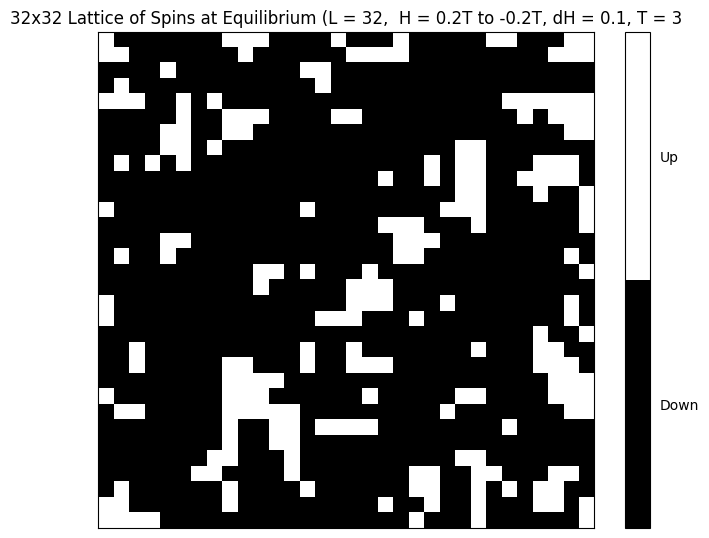

In [119]:
L = 32      #size of the lattice
H = 0.2     #initial magnetic field
dH = 0.1    #change in magnetic field
nH = 4      #number of different magnetic fields
T = 3       #temperature
n = 200     #number of steps per particle
a = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
a.Metropolis(n, save_spins = True)
a.plot_em(save_fig = True)
a.plot_spins(save_fig = True)
a.animate_spins(save_fig = True)

The average magnetization of the particles in $H=0.2$ is about 0.6, depending on the run of the simulation, accounting for the last 80% of magnetizations calculated in the field. Under the same conditions for measuring the average value of magnetization in the field of $H=0.1$, the magnetization is about 0.3. Then the average magnetization for the next three fields ($H=0$, $H=-0.1$, and $H=-0.2$) are 0, -4, and -5, respectively. When $H=0$, we see the phase transition to possibly be paramagnetism as the change in magnetism is gradual and not sudden for the system aligning itself with the magnetic field, Although there is a rather sigmoidal nature to the graph that would suggest that this system remains as a ferromagnet.

$\textbf{Part B.}$
Set $H=0.2$ and $T=1.8$ and run $\textbf{Part A}$ under these new conditions. What happens now? Is there evidence of a sudden change in $m$ as you change the direction of the field?

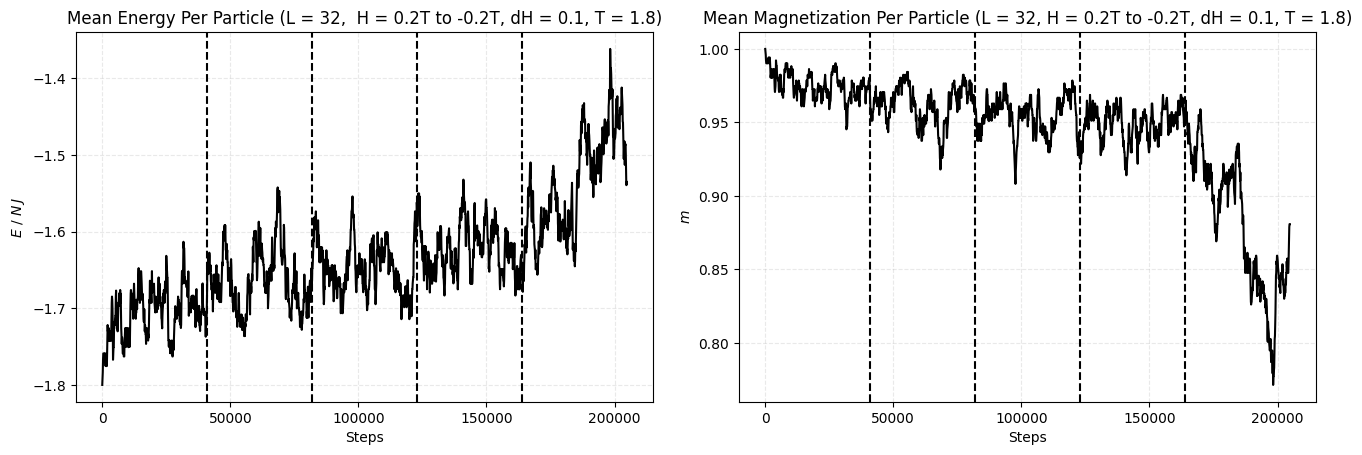

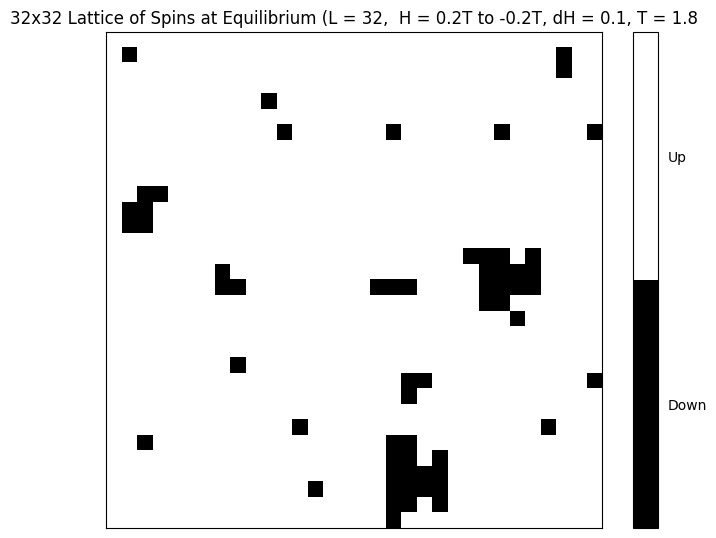

In [11]:
L = 32      #size of the lattice
H = 0.2     #intial magnetic field 
dH = 0.1    #change in magnetic field
nH = 4      #number of different magnetic fields
T = 1.8     #temperature
n = 200     #number of steps per particle
b = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
b.Metropolis(n, save_spins = True)
b.plot_em(save_fig = True)
b.plot_spins(save_fig = True)
b.animate_spins(save_fig = True)

Due to the system being under the critical temperature, we see that the magnetization stays above zero and no phase transition is observed for the magnetic fields. Due to the effect of the magnetic field, when $H\geq0$, the system stays completely ferromagnetic and there is little change in the average energy and magnetization. When $H<0$, the magnetic field starts to provide a torque on the particles to align their spins to be parallel rather than antiparallel, but the cooperation of the particles resists the change in spin orientation to be parallel with the magnetic field. As the magnetic field is changed to a more negative value, we see a larger shift in the magnetism which is a ferromagnetic behavior and suggest that the system is a ferromagnetic, which we would assume based on the system being below the critical temperature. 

$\textbf{Part C.}$ Use program IsingHysteresis with $T=1.8$, the intiial magnetic field $H=1$, and 10mcs for each value of $H$. The program plots the mean magnetization for each value of $H$, and changes by $\Delta H$ until $H$ reaches $H=-1$, when it changes $\Delta H$ to $-\Delta H$. Describe what you obtain and why it occurred. The resulting curve is called a hysteresis loop, and is characteristic of discontinuous phase transitions.

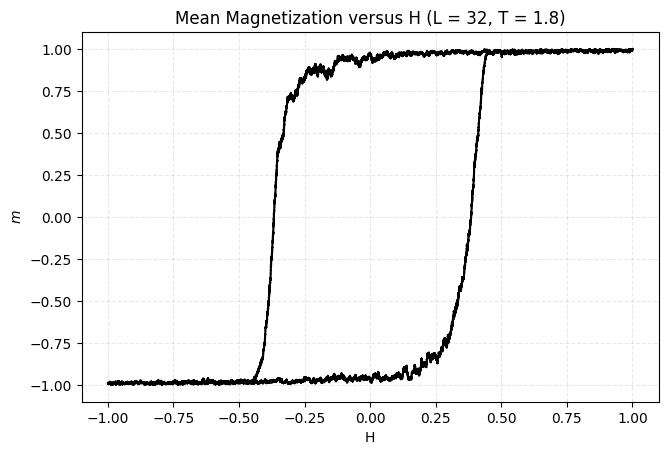

In [17]:
L = 32      #size of the lattice
H = 1     #initial magnetic field
dH = 0.01    #change in magnetic field
nH = 10      #number of different magnetic fields
T = 1.8       #temperature
n = 400     #number of steps per particle
c = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
c.IHyst(n, save_spins = True)
c.plot_emh(save_fig = True)

$\textbf{Part D.}$ Use mcs = 1 and mcs = 100 and explain the differences you see

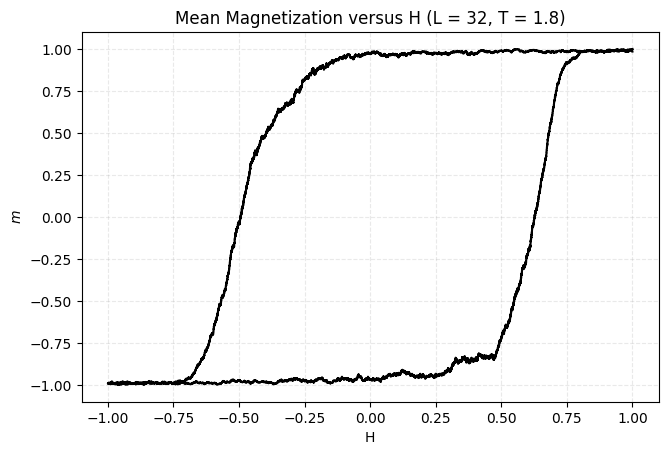

In [20]:
L = 32      #size of the lattice
H = 1     #initial magnetic field
dH = 0.01    #change in magnetic field
nH = 1      #number of different magnetic fields
T = 1.8       #temperature
n = 400     #number of steps per particle
d = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
d.IHyst(n, save_spins = True)
d.plot_emh(save_fig = True)

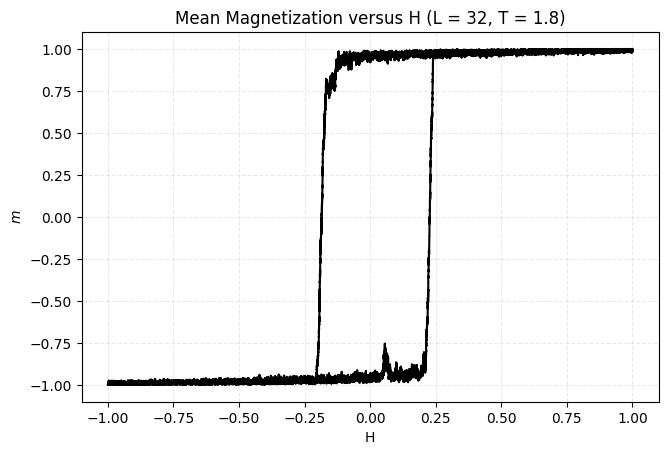

In [21]:
L = 32      #size of the lattice
H = 1     #initial magnetic field
dH = 0.01    #change in magnetic field
nH = 100      #number of different magnetic fields
T = 1.8       #temperature
n = 300     #number of steps per particle
d = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
d.IHyst(n, save_spins = True)
d.plot_emh(save_fig = True)

$\textbf{Extension}$

I wanted to see the effects that a divergent magentic field would have on the mean energy and mean magnitization and compare it to the previous results.

"\nea3 = Ising2D(L, H, dH, nH, T, 'Step', 'radial')\nea3.Gradient(n, save_spins = True)\nea3.plot_em(save_fig = False)\nea3.plot_spins(save_fig = False)\n#ea3.animate_spins(save_fig = False)"

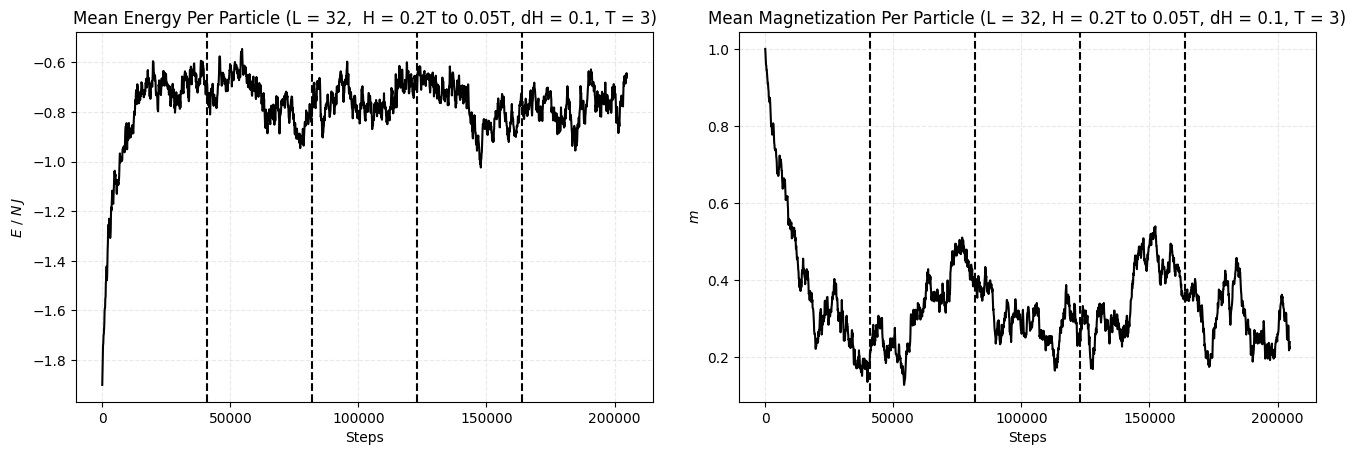

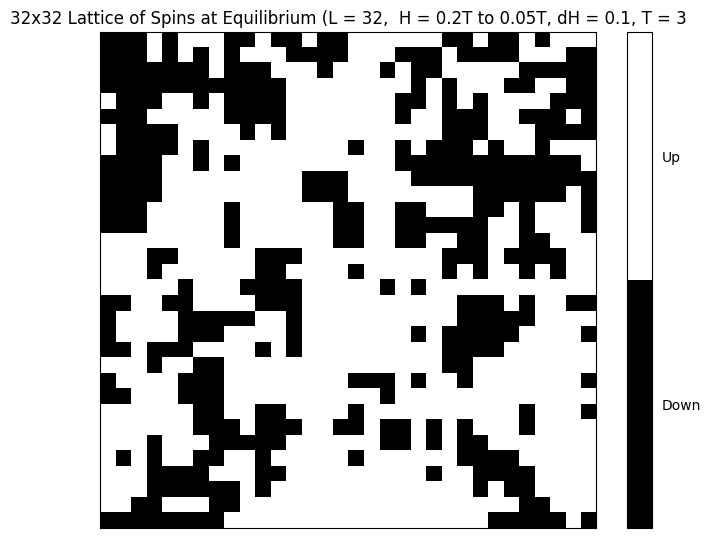

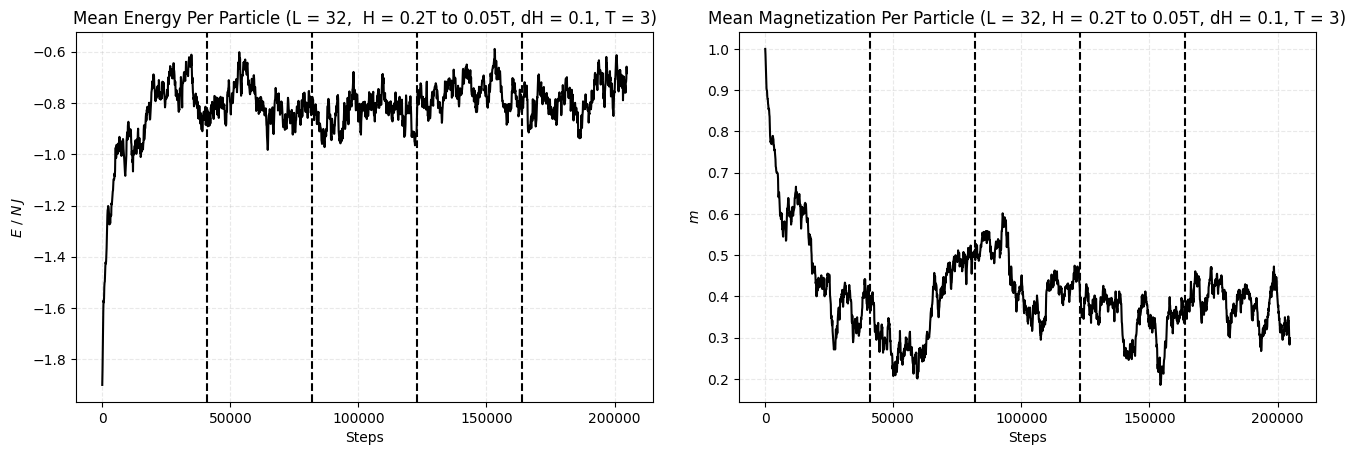

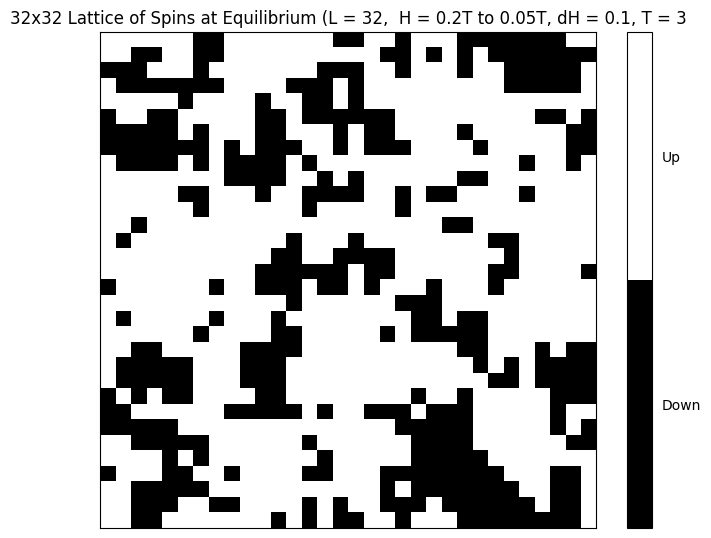

In [124]:
L = 32      #size of the lattice
H = 0.2     #initial magnetic field
dH = 0.1    #change in magnetic field
nH = 4      #number of different magnetic fields
T = 3       #temperature
n = 200     #number of steps per particle
ea1 = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
ea1.Gradient(n, save_spins = True)
ea1.plot_em(save_fig = False)
ea1.plot_spins(save_fig = False)
#ea1.animate_spins(save_fig = False)

ea2 = Ising2D(L, H, dH, nH, T, 'Step', 'wave')
ea2.Gradient(n, save_spins = True)
ea2.plot_em(save_fig = False)
ea2.plot_spins(save_fig = False)
#ea2.animate_spins(save_fig = False)
'''
ea3 = Ising2D(L, H, dH, nH, T, 'Step', 'radial')
ea3.Gradient(n, save_spins = True)
ea3.plot_em(save_fig = False)
ea3.plot_spins(save_fig = False)
#ea3.animate_spins(save_fig = False)'''

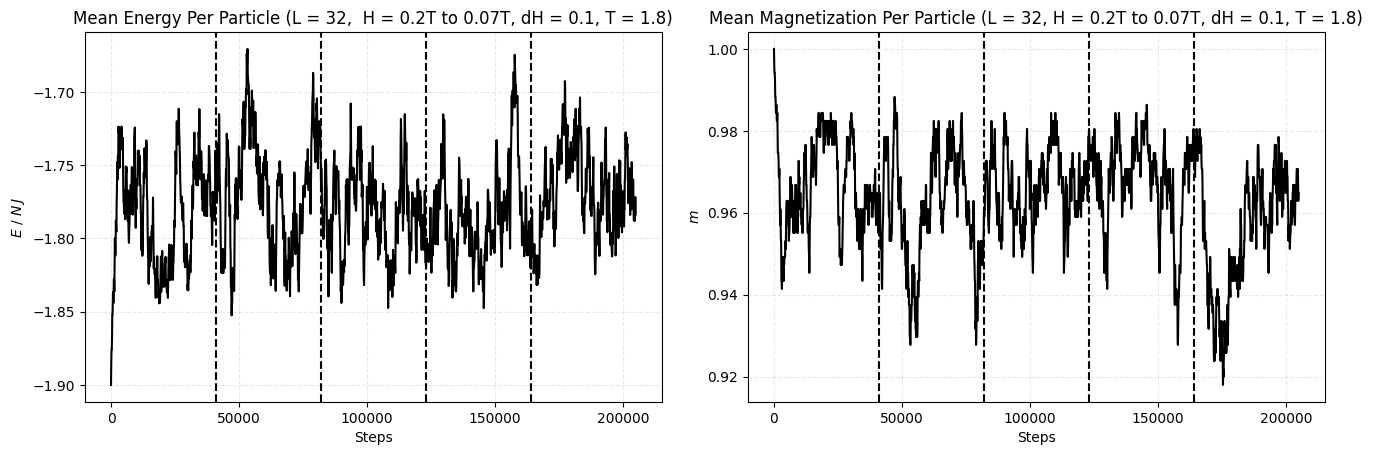

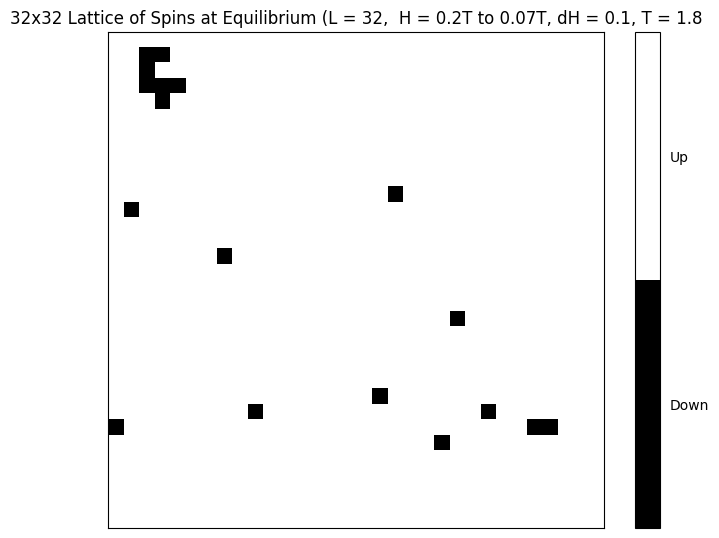

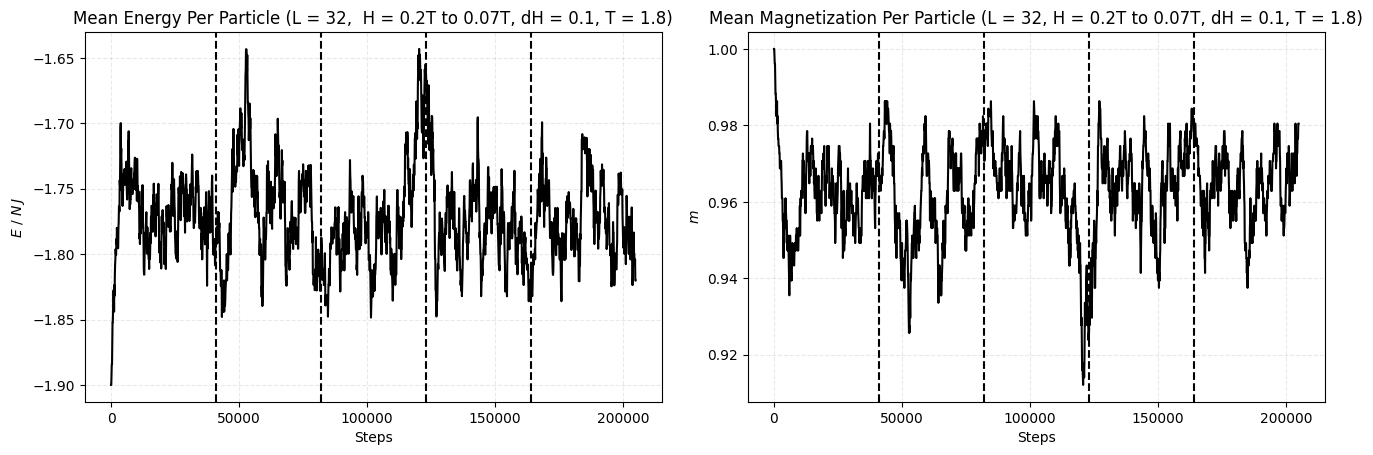

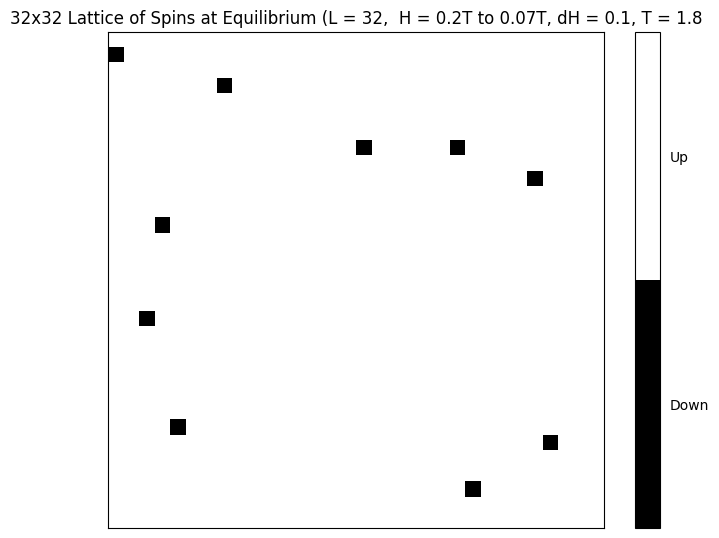

In [137]:
L = 32      #size of the lattice
H = 0.2     #initial magnetic field
dH = 0.1    #change in magnetic field
nH = 4      #number of different magnetic fields
T = 1.8       #temperature
n = 200     #number of steps per particle
ea1 = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
ea1.Gradient(n, save_spins = True)
ea1.plot_em(save_fig = True)
ea1.plot_spins(save_fig = True)
#ea1.animate_spins(save_fig = False)

ea2 = Ising2D(L, H, dH, nH, T, 'Step', 'wave')
ea2.Gradient(n, save_spins = True)
ea2.plot_em(save_fig = True)
ea2.plot_spins(save_fig = True)
#ea2.animate_spins(save_fig = False)

ValueError: x and y must have same first dimension, but have shapes (160000,) and (1760000,)

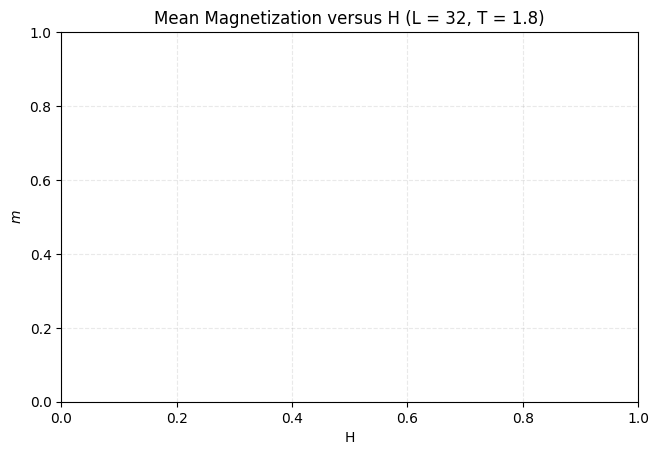

In [136]:
L = 32      #size of the lattice
H = 1     #initial magnetic field
dH = 0.01    #change in magnetic field
nH = 10      #number of different magnetic fields
T = 1.8       #temperature
n = 400     #number of steps per particle
ec1 = Ising2D(L, H, dH, nH, T, 'Step', 'linear')
ec1.GHyst(n, save_spins = True)
ec1.plot_emh(save_fig = False)


ec2 = Ising2D(L, H, dH, nH, T, 'Step', 'wave')
ec2.GHyst(n, save_spins = True)
ec2.plot_emh(save_fig = False)